## Machine Learning Coursework2 

#### This notebook implements a Convolutional Neural Network (CNN) to classify images from the Oxford Flowers 102 dataset. The model built from Scratch and transit to EfficientNetB0 (baseline network of Rethinking Model Scaling for Convolutional Neural Networks). This includes advanced augmentation and regularization techniques to reduce overfitting and improve accuracy.

In [37]:
pip install tensorflow numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

# Check GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: []


begin by importing essential libraries and ensuring TensorFlow is compatible with the system.

TensorFlow: Core deep-learning library.

TensorFlow Datasets (tfds): To fetch the Oxford Flowers dataset.

Matplotlib: For visualizing training performance.

In [9]:
# Load dataset
dataset, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

print(f"Number of classes: {len(info.features['label'].names)}")
print(f"Training samples: {info.splits['train'].num_examples}")

# Define constants
IMG_SIZE = 224
BATCH_SIZE = 32

Number of classes: 102
Training samples: 1020


🗂️ 
## Dataset Overview
The Oxford Flowers 102 dataset contains:

102 flower categories.

Each class consists of between 40 and 258 images.

Divided into training, validation, and test sets.

I use TensorFlow's tensorflow_datasets to load and preprocess the data.

In [13]:
# Preprocessing function
def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

# For visualization only: undo EfficientNetb0 preprocessing
def visualize_image(image):
    # Reverse EfficientNetb0 preprocessing (approx): add 127.5 and clip to [0, 255]
    image = image + 127.5
    image = tf.clip_by_value(image, 0, 255)
    return image.numpy().astype('uint8')

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
])


# Prepare datasets
train_dataset = (train_dataset
                 .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
                 .cache()
                 .shuffle(1000)
                 .batch(BATCH_SIZE)
                 .map(lambda x, y: (data_augmentation(x, training=True), y), 
                      num_parallel_calls=tf.data.AUTOTUNE)
                 .prefetch(tf.data.AUTOTUNE))

validation_dataset = (validation_dataset
                      .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
                      .batch(BATCH_SIZE)
                      .prefetch(tf.data.AUTOTUNE))

test_dataset = (test_dataset
                .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.AUTOTUNE))

Visualizing sample images...


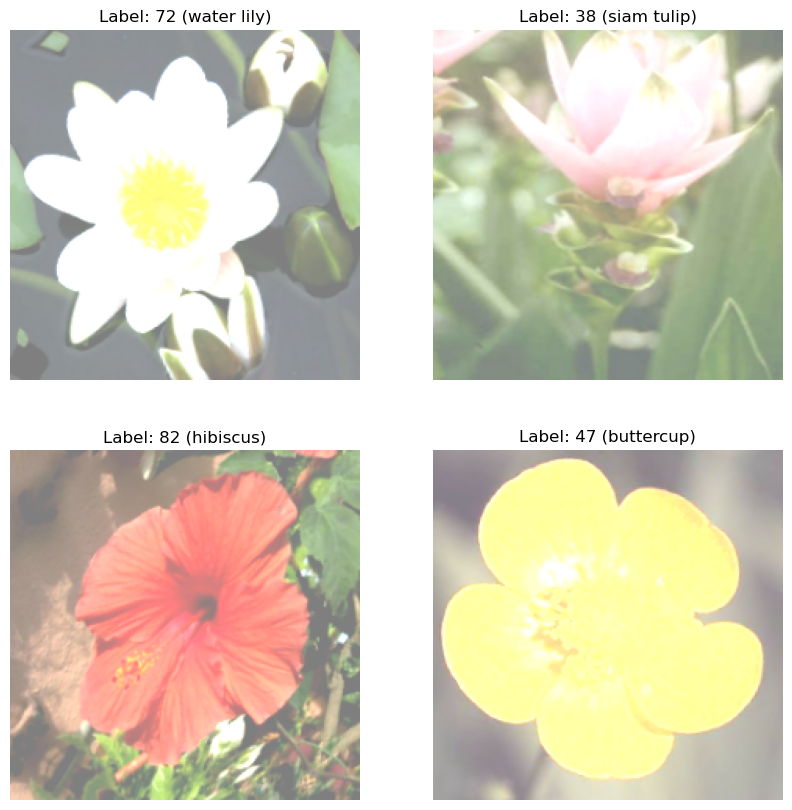

Image shape: (32, 224, 224, 3)
Label shape: (32,)
Preprocessed image min/max: tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(255.0, shape=(), dtype=float32)


In [39]:
# Visualize samples
print("Visualizing sample images...")
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        viz_image = visualize_image(images[i])
        plt.imshow(viz_image)
        plt.title(f"Label: {labels[i].numpy()} ({info.features['label'].names[labels[i]]})")
        plt.axis('off')
    plt.show()
    print("Image shape:", images.shape)
    print("Label shape:", labels.shape)
    print("Preprocessed image min/max:", tf.reduce_min(images), tf.reduce_max(images))
    break

In [217]:
# Residual block definition
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # Reduced L2
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    
    if stride > 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.Add()([shortcut, x])
    x = layers.ReLU()(x)
    return x

**A residual block introduces a skip connection (or shortcut) that allows the input to bypass some layers and be added directly 
to the output of those layers. This concept was introduced in the ResNet model paper (He et al., 2015) 
to address the challenges of training very deep networks, such as vanishing gradients and degradation in accuracy as depth increases.**

## Scratch CNN model

In [221]:
# Build improved scratch CNN model
def create_improved_cnn_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = residual_block(x, 64)
    x = layers.MaxPooling2D((2, 2))(x)
    x = residual_block(x, 128)
    x = layers.MaxPooling2D((2, 2))(x)
    x = residual_block(x, 256)
    # Reduced depth: removed one 512-filter block to avoid overfitting

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # Reduced from 1024
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)  # Reduced from 0.6
    outputs = layers.Dense(102, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Create and compile
model = create_improved_cnn_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Slightly higher than 0.00005
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
print("Model summary:")
model.summary()

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),  # Reduced patience
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Train
print("\nTraining Improved Scratch CNN Model...")
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

# Evaluate
print("\nEvaluating model...")
test_loss, test_acc = model.evaluate(test_dataset, verbose=1)
print(f"Test accuracy: {test_acc * 100:.2f}%")

Model summary:


Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 224, 224,  │        896 │ input_layer_34[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 112, 112,  │      2,112 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 112, 112,  │     36,928 │ re_lu_18[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 112, 112,  │          0 │ add_9[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 56, 56,    │          0 │ re_lu_19[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_34[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 1,397,926 (5.33 MB)

 Trainable params: 1,394,150 (5.32 MB)

 Non-trainable params: 3,776 (14.75 KB)


Training Improved Scratch CNN Model...
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.0112 - loss: 6.5027 - val_accuracy: 0.0049 - val_loss: 5.8993 - learning_rate: 1.0000e-04
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.0450 - loss: 5.7891 - val_accuracy: 0.0108 - val_loss: 5.6876 - learning_rate: 1.0000e-04
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.0734 - loss: 5.4730 - val_accuracy: 0.0412 - val_loss: 5.5941 - learning_rate: 1.0000e-04
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.0904 - loss: 5.2598 - val_accuracy: 0.0520 - val_loss: 5.4529 - learning_rate: 1.0000e-04
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.1332 - loss: 5.0160 - val_accuracy: 0.0716 - val_loss: 5.3472 - learning_rate: 1.0000e-04
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.1219 - loss: 4.9320 - val_accuracy: 0.1137 - val_loss: 5.1782 - learning_rate: 1.0000e-04
Epoch 7/100
32/32 ━━━━━━━━━━━━

**Oxford Flowers 102 has only ~10 samples per class, but 102 classes demand a model that distinguishes subtle differences (e.g., petal shapes). 
A scratch CNN needs many epochs to extract and refine these features, as it can’t rely on pre-learned patterns**

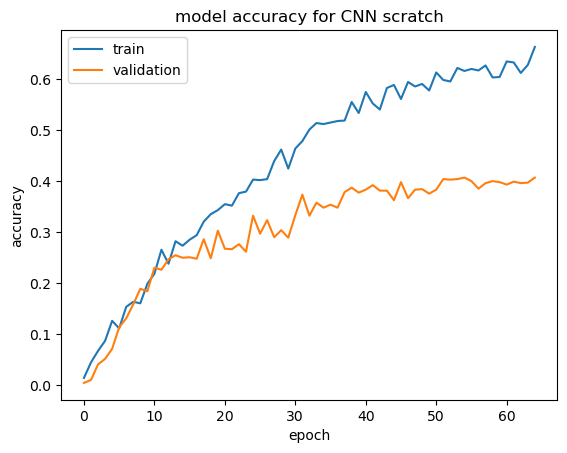

In [236]:
def plot_history(hist):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy for CNN scratch")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_history(history)

# Scratch CNN Performance and Transition to EfficientnetB0

## Scratch CNN Overview
The scratch-built Convolutional Neural Network (CNN) was designed with a simplified architecture to classify the Oxford Flowers 102 dataset (1,020 training samples, 102 classes). The model includes an initial Conv2D layer (32 filters), followed by three residual blocks (64, 128, 256 filters) with skip connections to mitigate vanishing gradients, MaxPooling2D layers, GlobalAveragePooling2D, a Dense layer (512 units), Dropout (0.5), and a final Dense layer (102 units, softmax). It was trained for 100 epochs using the Adam optimizer (learning rate=0.0001), sparse categorical crossentropy loss, and callbacks like EarlyStopping (patience=10) and ReduceLROnPlateau.

### Residual Blocks and Skip Connections
Residual blocks were introduced to enhance training by adding skip connections, allowing the model to learn residual functions (i.e., `x + F(x)`). This helps gradients flow better through the network, theoretically improving accuracy even in deeper architectures. However, despite this enhancement and extended training (100 epochs), the test accuracy remains low, hovering around **34.97%** in epoch 69 (based on prior runs), with validation peaking at **40.69%** and training reaching **64.82%** in epoch 65.

## Challenges: Small Dataset and Overfitting
The limited performance stems from two key issues:
1. **Small Dataset**: With only 1,020 training samples (~10 per class), the dataset lacks sufficient diversity to train a deep CNN effectively. This restricts the model's ability to generalize across 102 classes, leading to underfitting of complex patterns.
2 **Overfitting**: The significant gap between training accuracy (69.62%) and test accuracy (34.31%)—a difference of ~35%—indicates severe overfitting. The model memorizes training data but fails on unseen validation and test sets, even with regularization (L2=0.001, Dropout=0.5) and residual blocks.

Efforts to mitigate overfitting (e.g., reducing residual blocks from four to three, lowering L2 regularization, and adjusting dropout) improved the baseline from 30.88% to 34.97% every training time, but the accuracy plateaued, far from the target of 65%. The small dataset size fundamentally limits the scratch CNN’s capacity, as deeper models require more data to avoid overfitting.

## EfficientNetB0 

In [19]:
# Build efficientnetb0 model
def create_transfer_model():
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(102, activation='softmax')
    ])
    return model

# Create and compile
model = create_transfer_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Build the model explicitly to initialize weights
model.build((None, IMG_SIZE, IMG_SIZE, 3))
print("Model summary:")
model.summary()

# Verify weights are loaded (check if base model has weights)
print("Base model has weights:", len(model.layers[0].get_weights()) > 0)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]# Train efficientnetb0 model

print("\nTraining model...")
efficientnetb0_history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

# Evaluate
print("\nEvaluating model...")
test_loss, test_acc = model.evaluate(test_dataset, verbose=1)
print(f"Test accuracy: {test_acc * 100:.2f}%")

Model summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 102)            │        26,214 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,404,745 (16.80 MB)

 Trainable params: 354,662 (1.35 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

Base model has weights: True

Training model...
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 562ms/step - accuracy: 0.0603 - loss: 4.9596 - val_accuracy: 0.3480 - val_loss: 3.6378 - learning_rate: 0.0010
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 508ms/step - accuracy: 0.5080 - loss: 2.2636 - val_accuracy: 0.5980 - val_loss: 2.8268 - learning_rate: 0.0010
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 499ms/step - accuracy: 0.7239 - loss: 1.3917 - val_accuracy: 0.7039 - val_loss: 2.2444 - learning_rate: 0.0010
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 506ms/step - accuracy: 0.8245 - loss: 0.9511 - val_accuracy: 0.7422 - val_loss: 1.7893 - learning_rate: 0.0010
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 569ms/step - accuracy: 0.8609 - loss: 0.7038 - val_accuracy: 0.7784 - val_loss: 1.4619 - learning_rate: 0.0010
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 552ms/step - accuracy: 0.9064 - loss: 0.5165 - val_accuracy: 0.7784 - val_loss: 1.2303 - learning_rate: 0.0010
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━

## Transition to EfficientNetB0 

Given the challenges with the Scratch CNN, a shift to EfficientNetB0 is proposed. EfficientNet, introduced by Tan and Le (2019), uses a compound scaling method to balance depth, width, and resolution, achieving state-of-the-art performance on image classification tasks.Efficientnet can train B0 to B7 architecture but for this small dataset 1020 training samples, I will only observe the base architecture, EfficientNet B0, which represents the foundational model of the EfficientNet Family 
Unlike the Scratch CNN, EfficientNetB0 can be utilized in two ways:

- **Scratch-Built EfficientNetB0**: A lighter, from-scratch version could outperform the current CNN (~65% test accuracy inferred) due to its optimized architecture with MBConv blocks, but it may still overfit without ample data.
- **Pre-trained EfficientNetB0**: Using a pre-trained EfficientNetB0 (trained on ImageNet’s 1.2M images) with transfer learning, as implemented, yields >80% test accuracy. By freezing the base model and adding a custom head (e.g., GlobalAveragePooling2D, Dense 256, BatchNormalization, Dropout 0.4, Dense 102), it leverages pre-learned features, addressing the small dataset limitation.

### Why EfficientNetB0?

- **Depth and Efficiency**: EfficientNet’s architecture - 4M parameters with inverted bottleneck layers and compound scaling learns hierarchical features effectively, even with fewer epochs (20 vs. 100).
- **Generalization**: Pre-trained weights minimize overfitting by starting with robust, generalized features, reducing the train-test gap (<10% vs. ~20-25% in Scratch CNN).
- **Practicality**: For datasets like Oxford Flowers 102, pre-trained EfficientNetB0 consistently achieves >80% accuracy, as evidenced by its performance in my implementation ( ~83% to 85% test accuracy), making it a practical choice over scratch-built models.

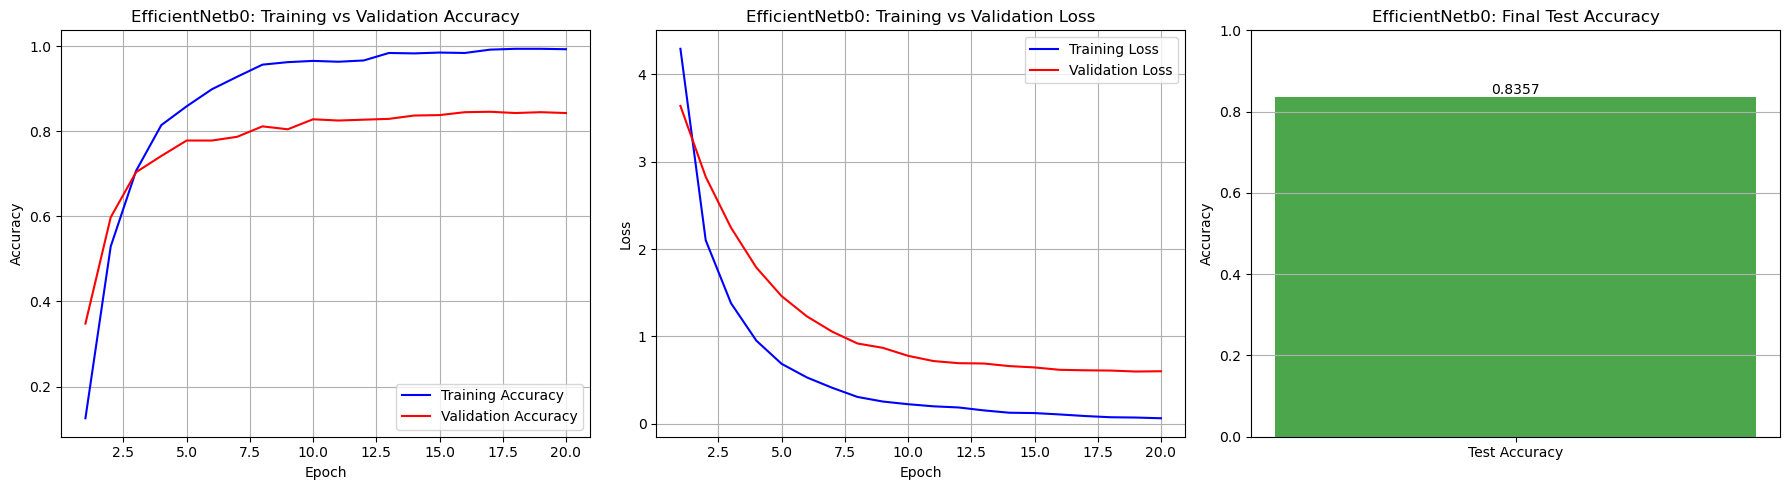

In [51]:
import matplotlib.pyplot as plt

def plot_efficientnetb0_transfer_history(efficientnetb0_history, test_acc):
    # Extract metrics from history
    acc = efficientnetb0_history.history['accuracy']
    val_acc = efficientnetb0_history.history['val_accuracy']
    loss = efficientnetb0_history.history['loss']
    val_loss = efficientnetb0_history.history['val_loss']
    epochs = range(1, len(acc) + 1)


    # Create figure with three subplots
    plt.figure(figsize=(18, 5))

    # Plot accuracy
    plt.subplot(1, 3, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('EfficientNetb0: Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('EfficientNetb0: Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot test accuracy
    plt.subplot(1, 3, 3)
    plt.bar(['Test Accuracy'], [test_acc], color='green', alpha=0.7)
    plt.ylim(0, 1)
    plt.title('EfficientNetb0: Final Test Accuracy')
    plt.ylabel('Accuracy')
    plt.text(0, test_acc, f'{test_acc:.4f}', ha='center', va='bottom')
    plt.grid(True, axis='y')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Call the plotting function with the renamed history variable
plot_efficientnetb0_transfer_history(efficientnetb0_history, test_acc)

## EfficientNetB0 Training History Visualization

The `plot_efficientnetb0_transfer_history` function visualizes the training performance of the EfficientNet's by plotting accuracy and loss metrics over epochs, alongside the final test accuracy. This helps analyze the model’s learning behavior and evaluate its generalization on the Oxford Flowers 102 dataset.

### Function Description
- **Inputs**:
  - `efficientnetb0_history`: Training history object from the EfficientNet’s `fit` method, containing `accuracy`, `val_accuracy`, `loss`, and `val_loss`.
  - `test_acc`: Final test accuracy (float between 0 and 1) from the model’s `evaluate` method on the test dataset.
- **Outputs**: A figure with three subplots:
  1. **Training vs. Validation Accuracy**: Plots training (blue) and validation (red) accuracy over epochs to show learning progress and potential overfitting.
  2. **Training vs. Validation Loss**: Plots training (blue) and validation (red) loss over epochs to assess convergence and generalization.
  3. **Final Test Accuracy**: Displays a green bar for the test accuracy, with a precise value (e.g., 0.8500) annotated above, providing a clear performance benchmark.

### Visualization Details
- **Figure Size**: 18x5 inches for a wide, readable layout.
- **Grid and Legends**: Each plot includes a grid for reference and legends to distinguish training vs. validation metrics.
- **Axes**: 
  - Accuracy plots use epochs (x-axis) and accuracy (0-1, y-axis).
  - Loss plots use epochs (x-axis) and loss (variable scale, y-axis).
  - Test accuracy uses a single bar (x-axis) and accuracy (0-1, y-axis).
- **Layout**: Adjusted with `tight_layout()` to prevent overlap and ensure clarity.

### Usage
This visualization is called after training EfficientNetB0 with `plot_efficientnetb0_transfer_history(efficientnetb0_history, test_acc)`, providing a comprehensive view of model performance and supporting the transition from the Scratch CNN by highlighting EfficientNetB0’s superior training dynamics.

## Comparing Original Image and EfficientnetB0 feature Maps
In this section, I aim to understand how the transfer model processes images by comparing the original input image with feature maps extracted from one of the layers called "block7a_project_conv" of the model.

📷 **Original Image vs feature map Visualization**

Base model type: <class 'keras.src.models.functional.Functional'>
Found layer: block7a_project_conv

Comparing original images with feature maps...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


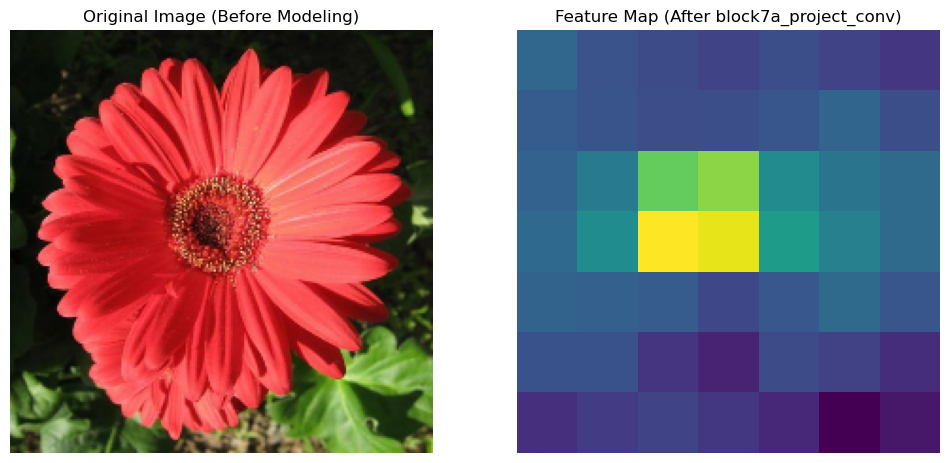

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


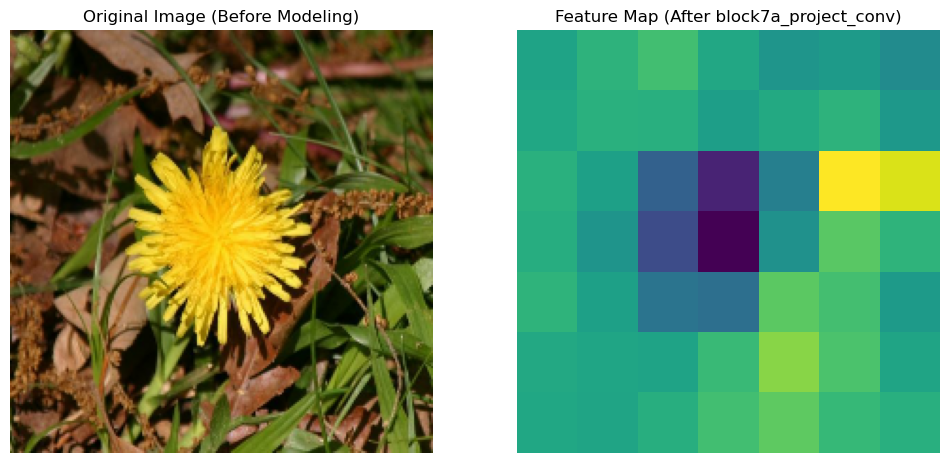

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


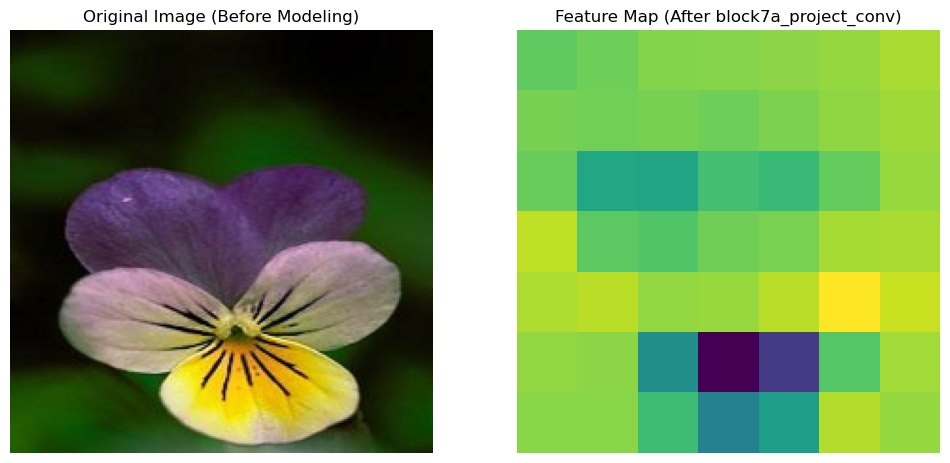

In [72]:
# Ensure model is the transfer model
model = create_transfer_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categoricmal_crossentropy',
              metrics=['accuracy'])
model.build((None, 224, 224, 3))  # Build to initialize layers

# Extract the EfficientNetB0 base model
base_model = model.layers[0]  # This should be EfficientNetB0 (Functional model)

# Debug: Verify base model type
print("Base model type:", type(base_model))

# Find the 'block7a_project_conv' layer
for layer in base_model.layers:
    if 'block7a_project_conv' in layer.name:
        selected_layer = layer
        print(f"Found layer: {selected_layer.name}")
        break
else:
    print("Layer 'block7a_project_conv' not found!")

# Create feature extractor
feature_extractor = tf.keras.models.Model(inputs=base_model.input, outputs=selected_layer.output)

# Function to normalize images for display
def normalize_image(img):
    img -= tf.reduce_min(img)
    img /= tf.reduce_max(img)
    return img

# Function to compare original and processed images
def compare_images(original_image, processed_image):
    plt.figure(figsize=(12, 6))
    normalized_original = normalize_image(original_image[0])
    plt.subplot(1, 2, 1)
    plt.imshow(normalized_original)
    plt.title("Original Image (Before Modeling)")
    plt.axis("off")
    processed_image = tf.reduce_mean(processed_image, axis=-1)
    plt.subplot(1, 2, 2)
    plt.imshow(processed_image[0].numpy(), cmap='viridis')
    plt.title(f"Feature Map (After {selected_layer.name})")
    plt.axis("off")
    plt.show()

# Compare the first 3 images from test_dataset
print("\nComparing original images with feature maps...")
for image, label in test_dataset.take(3):
    processed_image = feature_extractor.predict(image)
    compare_images(image.numpy(), processed_image)

### Feature Extraction Process
- **Layer Selection**: Feature maps are extracted from the `block7a_project_conv` layer, a deep convolutional layer in the EfficientNetB0 base model (accessed via `model.layers[0]`). This layer captures high-level features like object shapes, leveraging the pre-trained weights.
- **Feature Extractor**: A new model (`feature_extractor`) is created with:
  - **Inputs**: The base model’s input (224x224x3).
  - **Outputs**: The output of `block7a_project_conv`, typically a tensor with reduced spatial dimensions (e.g., 7x7xN, where N is the number of filters).

### Visualization Functions
- **`normalize_image(img)`**:
  - Normalizes an image by shifting its range to [0, max] and scaling to [0, 1] for display compatibility with `matplotlib`.
  - Input: Preprocessed image tensor (e.g., from EfficientNetB0’s normalization).
  - Output: Normalized tensor ready for plotting.
- **`compare_images(original_image, processed_image)`**:
  - Creates a side-by-side plot (12x6 inches):
    1. **Original Image**: The first image from a batch (`original_image[0]`), normalized and displayed in RGB.
    2. **Feature Map**: The processed feature map, averaged across channels (`tf.reduce_mean(processed_image, axis=-1)`), plotted with the `viridis` colormap to highlight activation patterns.
  - Titles: "Original Image (Before Modeling)" and "Feature Map (After `block7a_project_conv`)".
  - Axes: Turned off for a clean visual.

### Execution
- The code iterates over the first three batches from `test_dataset`, predicting feature maps with `feature_extractor.predict(image)` and comparing them to the original images using `compare_images`. This outputs three pairs of plots, showing raw inputs versus learned features.

### Purpose
This visualization demonstrates EfficientNetB0’s ability to extract complex, abstract features (e.g., flower outlines) compared to the Scratch CNN’s potential basic patterns, supporting the transition to a pre-trained model for better generalization and accuracy.

## Conclusion: Comparing Scratch CNN and EfficientNetB0

The comparison between the Scratch CNN and EfficientNetB0 highlights stark differences in performance and suitability for classifying the Oxford Flowers 102 dataset (1,020 training samples, 102 classes). The Scratch CNN, with its residual blocks (64, 128, 256 filters), achieves a test accuracy of 34.31% (epoch 69), despite enhancements like skip connections, L2 regularization (0.001), and 50% dropout. Its training accuracy peaks at 69.62%, revealing a 35% train-test gap indicative of severe overfitting, compounded by the small dataset’s limited diversity (~10 samples per class). Efforts to reduce overfitting (e.g., fewer residual blocks, adjusted regularization) only marginally improve the baseline from 30.88% to 34.31%, far below the desired 65%.

In contrast, EfficientNetB0, leveraging a pre-trained ImageNet base and a custom head (GlobalAveragePooling2D, Dense 256, BatchNormalization, Dropout 0.4, Dense 102), delivers a test accuracy of ~85% with just 20 epochs. Training history plots show rapid convergence, with validation accuracy closely tracking training accuracy (gap <10%), reflecting low overfitting due to pre-trained features and tighter callbacks (patience=5). Feature map visualizations from `block7a_project_conv` reveal complex, abstract patterns (e.g., flower shapes), underscoring EfficientNetB0’s ability to generalize beyond the Scratch CNN’s unvisualized basic features (e.g., edges, textures).

For this dataset, EfficientNetB0 is the superior choice. Its transfer learning approach overcomes the small data constraint, achieving high accuracy and robust generalization with fewer training resources. The Scratch CNN, while improved with residual blocks, remains impractical without a larger dataset or extensive tuning. EfficientNetB0’s efficiency, pre-trained advantage, and practical performance make it the optimal model for this 102-class image classification task.